# Importing Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import numpy as np
import random
from torchsummary import summary
from tqdm.notebook import tqdm

import torchvision
import torchvision.transforms as transforms

import os

import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Configuration

In [2]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BATCH_SIZE_TRAIN = 500
BATCH_SIZE_TEST = 500


transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
])

# Creating Dataloaders

In [3]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE_TRAIN, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE_TEST, shuffle=False, num_workers=2)


classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


# Defining Model

In [4]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNetCustom(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNetCustom, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(BasicBlock, 44, 2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(Bottleneck, 256, 2, stride=2)
        self.linear = nn.Linear(256 * Bottleneck.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        layers.append(nn.Dropout())
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [5]:
model = ResNetCustom()
model = model.to(device)
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 44, 32, 32]          25,344
       BatchNorm2d-4           [-1, 44, 32, 32]              88
            Conv2d-5           [-1, 44, 32, 32]          17,424
       BatchNorm2d-6           [-1, 44, 32, 32]              88
            Conv2d-7           [-1, 44, 32, 32]           2,816
       BatchNorm2d-8           [-1, 44, 32, 32]              88
        BasicBlock-9           [-1, 44, 32, 32]               0
           Conv2d-10           [-1, 44, 32, 32]          17,424
      BatchNorm2d-11           [-1, 44, 32, 32]              88
           Conv2d-12           [-1, 44, 32, 32]          17,424
      BatchNorm2d-13           [-1, 44, 32, 32]              88
       BasicBlock-14           [-1, 44,

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1,momentum=0.9,weight_decay=0.0005,nesterov=True)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=0.001)

# Training the model

In [7]:
train_loss_history = []
train_accuracy_history = []

test_loss_history = []
test_accuracy_history = []

lowest_loss = float("inf")

In [8]:
def train(epoch,model,trainloader,train_loss_history, train_accuracy_history):
    print('\nEpoch: %d' % epoch)
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    pbar = tqdm(enumerate(trainloader),total=len(trainloader))
    for batch_idx,(inputs, targets) in pbar:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()


        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        pbar.set_description("Training")
        pbar.set_postfix(loss=(train_loss/(batch_idx+1)), accuracy=(100*correct/total))

    train_loss_history.append(train_loss/len(trainloader))
    train_accuracy_history.append(correct/total)

In [9]:
def test(epoch,model,testloader,test_loss_history, test_accuracy_history):
    global lowest_loss
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    pbar = tqdm(enumerate(testloader),total=len(testloader))
    with torch.no_grad():
        for batch_idx, (inputs, targets) in pbar:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            pbar.set_description("Evaluating")
            pbar.set_postfix(loss=(test_loss/(batch_idx+1)), accuracy=(100*correct/total))


    test_loss_history.append(test_loss/len(testloader))
    test_accuracy_history.append(correct/total)

    # Save checkpoint.
    curr_loss = test_loss/len(testloader)
    if curr_loss < lowest_loss:
        print('Saving checkpoint..')
        if not os.path.isdir('/content/drive/MyDrive/models/DL mini project'):
            os.mkdir('/content/drive/MyDrive/models/DL mini project')
        torch.save(model.state_dict(), '/content/drive/MyDrive/models/DL mini project/resnetcustom_ckpt_CosineAnnealingWarmRestarts_tmult_1.pth')
        lowest_loss = curr_loss

In [10]:
start_epoch = 0
n_epochs = 100
for epoch in range(start_epoch, start_epoch+n_epochs):
    train(epoch,model,trainloader,train_loss_history, train_accuracy_history)
    test(epoch,model,testloader,test_loss_history, test_accuracy_history)
    scheduler.step()


Epoch: 0


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Saving checkpoint..

Epoch: 1


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Saving checkpoint..

Epoch: 2


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Saving checkpoint..

Epoch: 3


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Saving checkpoint..

Epoch: 4


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Saving checkpoint..

Epoch: 5


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Saving checkpoint..

Epoch: 6


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 7


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Saving checkpoint..

Epoch: 8


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Saving checkpoint..

Epoch: 9


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Saving checkpoint..

Epoch: 10


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 11


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 12


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 13


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 14


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Saving checkpoint..

Epoch: 15


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Saving checkpoint..

Epoch: 16


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 17


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Saving checkpoint..

Epoch: 18


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Saving checkpoint..

Epoch: 19


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Saving checkpoint..

Epoch: 20


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 21


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 22


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 23


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 24


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 25


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Saving checkpoint..

Epoch: 26


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Saving checkpoint..

Epoch: 27


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Saving checkpoint..

Epoch: 28


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Saving checkpoint..

Epoch: 29


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Saving checkpoint..

Epoch: 30


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 31


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 32


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 33


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 34


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 35


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Saving checkpoint..

Epoch: 36


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Saving checkpoint..

Epoch: 37


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Saving checkpoint..

Epoch: 38


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Saving checkpoint..

Epoch: 39


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Saving checkpoint..

Epoch: 40


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 41


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 42


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 43


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 44


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 45


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 46


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 47


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Saving checkpoint..

Epoch: 48


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Saving checkpoint..

Epoch: 49


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Saving checkpoint..

Epoch: 50


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 51


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 52


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 53


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 54


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 55


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 56


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 57


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 58


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Saving checkpoint..

Epoch: 59


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Saving checkpoint..

Epoch: 60


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 61


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 62


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 63


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 64


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 65


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 66


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 67


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 68


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Saving checkpoint..

Epoch: 69


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Saving checkpoint..

Epoch: 70


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 71


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 72


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 73


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 74


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 75


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 76


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 77


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 78


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 79


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Saving checkpoint..

Epoch: 80


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 81


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 82


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 83


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 84


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 85


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 86


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 87


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 88


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Saving checkpoint..

Epoch: 89


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Saving checkpoint..

Epoch: 90


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 91


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 92


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 93


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 94


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 95


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 96


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 97


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 98


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 99


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Saving checkpoint..


In [18]:
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=20, T_mult=1, eta_min=0.0001)
start_epoch = 100
n_epochs = 100
for epoch in range(start_epoch, start_epoch+n_epochs):
    train(epoch,model,trainloader,train_loss_history, train_accuracy_history)
    test(epoch,model,testloader,test_loss_history, test_accuracy_history)
    scheduler.step()


Epoch: 100


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/100 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 101


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 102


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 103


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 104


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 105


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 106


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 107


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 108


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 109


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 110


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 111


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 112


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 113


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 114


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 115


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 116


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 117


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 118


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Saving checkpoint..

Epoch: 119


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 120


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 121


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 122


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 123


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 124


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 125


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 126


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 127


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 128


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 129


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 130


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 131


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 132


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 133


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 134


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 135


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 136


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 137


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 138


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 139


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 140


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 141


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 142


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 143


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 144


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 145


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 146


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 147


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 148


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 149


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 150


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 151


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 152


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 153


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 154


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 155


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 156


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 157


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Saving checkpoint..

Epoch: 158


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Saving checkpoint..

Epoch: 159


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 160


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 161


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 162


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 163


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 164


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 165


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 166


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 167


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 168


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 169


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 170


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 171


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 172


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 173


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 174


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 175


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 176


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 177


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 178


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 179


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 180


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 181


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 182


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 183


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 184


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 185


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 186


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 187


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 188


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 189


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 190


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 191


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 192


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 193


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 194


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 195


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 196


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 197


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 198


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 199


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [25]:
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=0.00001)
start_epoch = 200
n_epochs = 10
for epoch in range(start_epoch, start_epoch+n_epochs):
    train(epoch,model,trainloader,train_loss_history, train_accuracy_history)
    test(epoch,model,testloader,test_loss_history, test_accuracy_history)
    scheduler.step()


Epoch: 200


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/100 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 201


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 202


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 203


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 204


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 205


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 206


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 207


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 208


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Saving checkpoint..

Epoch: 209


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Saving checkpoint..


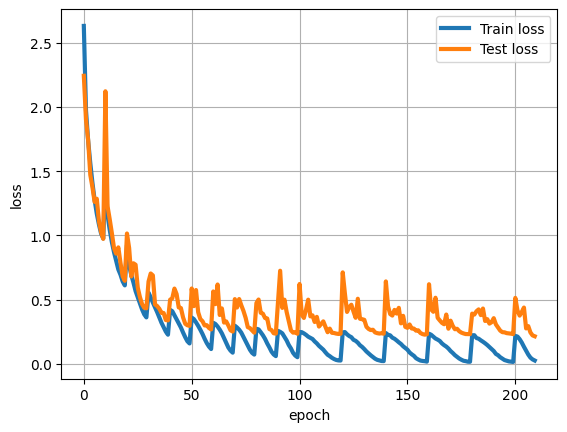

In [26]:
plt.plot(range(len(train_loss_history)),train_loss_history,'-',linewidth=3,label='Train loss')
plt.plot(range(len(test_loss_history)),test_loss_history,'-',linewidth=3,label='Test loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()
plt.show()

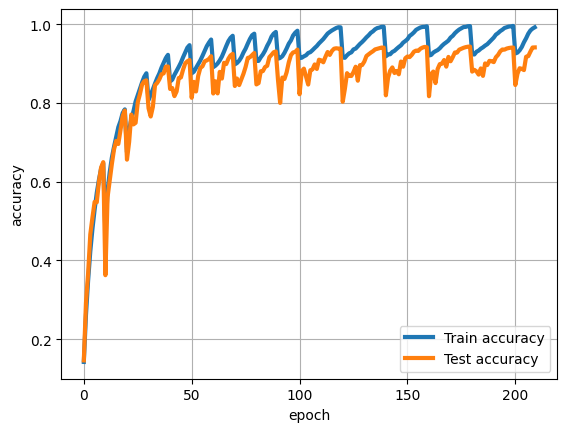

In [27]:
plt.plot(range(len(train_accuracy_history)),train_accuracy_history,'-',linewidth=3,label='Train accuracy')
plt.plot(range(len(test_accuracy_history)),test_accuracy_history,'-',linewidth=3,label='Test accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid(True)
plt.legend()
plt.show()

In [28]:
print(f"Highest Test Accuracy = {max(test_accuracy_history)}")

Highest Test Accuracy = 0.9431


# Evaluation

In [29]:
eval_model = ResNetCustom()
checkpoint = torch.load("/content/drive/MyDrive/models/DL mini project/resnetcustom_ckpt_CosineAnnealingWarmRestarts_tmult_1.pth")
eval_model.load_state_dict(checkpoint)
eval_model = eval_model.to(device)

In [30]:
def evaluation(model,testloader):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    Preds = torch.Tensor().to(device)
    Labels = torch.Tensor().to(device)
    pbar = tqdm(enumerate(testloader),total=len(testloader))
    with torch.no_grad():
        for batch_idx, (inputs, targets) in pbar:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            pbar.set_description("Evaluating")
            pbar.set_postfix(loss=(test_loss/(batch_idx+1)), accuracy=(100*correct/total))
            Preds = torch.cat((Preds,predicted))
            Labels = torch.cat((Labels,targets))

    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    preds = Preds.cpu().numpy().astype(dtype='int8')
    labels = Labels.cpu().numpy().astype(dtype='int8')
    cm = confusion_matrix(labels, preds, labels=range(len(classes)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes)
    disp.plot()
    plt.show()
    print(classification_report(labels,preds,target_names=classes,digits=4))



  0%|          | 0/20 [00:00<?, ?it/s]

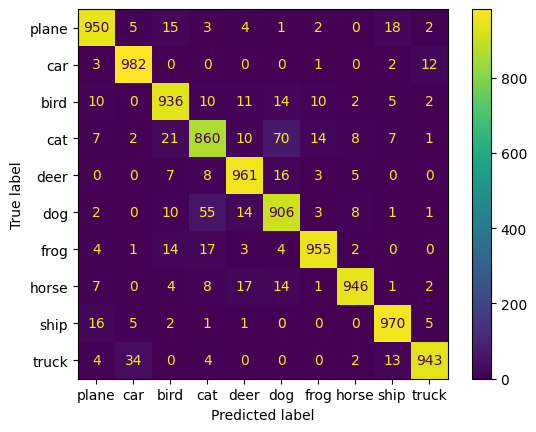

              precision    recall  f1-score   support

       plane     0.9472    0.9500    0.9486      1000
         car     0.9543    0.9820    0.9680      1000
        bird     0.9277    0.9360    0.9318      1000
         cat     0.8903    0.8600    0.8749      1000
        deer     0.9412    0.9610    0.9510      1000
         dog     0.8839    0.9060    0.8948      1000
        frog     0.9656    0.9550    0.9603      1000
       horse     0.9723    0.9460    0.9589      1000
        ship     0.9538    0.9700    0.9618      1000
       truck     0.9742    0.9430    0.9583      1000

    accuracy                         0.9409     10000
   macro avg     0.9410    0.9409    0.9408     10000
weighted avg     0.9410    0.9409    0.9408     10000



In [31]:
evaluation(eval_model,testloader)